# Force analysis of ActuAtor

In [2]:
%matplotlib inline
from functools import partial

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import automembrane.util as u
from automembrane.energy import getEnergy2DClosed, getEnergy2DClosed_notrace, getEnergy2DOpen

from pathlib import Path

from tqdm.notebook import tqdm

files = list(
    map(
        Path,
        [
            f"coordinates/{i}"
            for i in [
                "cell1/34D-grid2-s3-acta1_001_16.txt",
                "cell2/34D-grid3-ActA1_007_16.txt",
                "cell2/34D-grid3-ActA1_013_16.txt",
                "cell3/34D-grid2-s2_002_16.txt",
                "cell3/34D-grid2-s5_005_16.txt",
                "cell3/34D-grid3-ActA1_020_16.txt",
                "cell3/34D-grid3-s6_005_16.txt",
                "cell4/34D-grid2-s3_028_16.txt",
                "cell5/34D-grid3-ActA1_001_16.txt",
                "cell5/34D-grid3-ActA1_002_16.txt",
                "cell5/34D-grid3-ActA1_003_16.txt",
                "cell5/34D-grid3-ActA1_004_16.txt",
            ]
        ],
    )
)

images = {
    "34D-grid2-s3-acta1_001_16": 0.012723,
    "34D-grid3-ActA1_007_16": 0.015904,
    "34D-grid3-ActA1_013_16": 0.015904,
    "34D-grid2-s2_002_16": 0.015904,
    "34D-grid2-s5_005_16": 0.015904,
    "34D-grid3-ActA1_020_16": 0.015904,
    "34D-grid3-s6_005_16": 0.015904,
    "34D-grid2-s3_028_16": 0.015904,
    "34D-grid3-ActA1_001_16": 0.015904,
    "34D-grid3-ActA1_002_16": 0.015904,
    "34D-grid3-ActA1_003_16": 0.015904,
    "34D-grid3-ActA1_004_16": 0.015904,
}


parameters = {
    "Kb": 0.1,  # Bending modulus (pN um; original 1e-19 J) 
    "Kbc": 0,  # Constant of bending modulus vs protein density
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "At": 0,  # Preferred area
    "epsilon": 0,  # Binding energy per protein
    "Kv": 0,  # pressure-volume modulus
    "Vt": 0,  # Volume target
}

import matplotlib as mpl

u.matplotlibStyle(small=10, medium=12, large=14)

f_energy = partial(getEnergy2DClosed, **parameters)


Processing: 34D-grid2-s3-acta1_001_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing: 34D-grid3-ActA1_007_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing: 34D-grid3-ActA1_013_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

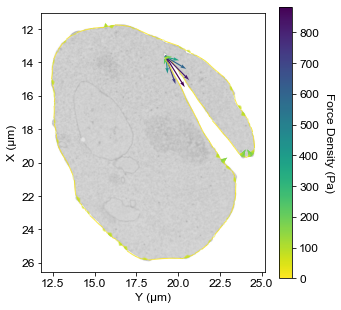

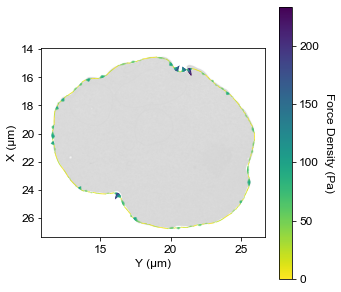

In [3]:
from scipy.interpolate import splprep, splev

n_vertices = 1000  # Number of vertices in resampling
dt = 5e-6  # Timestep
n_iter = 1000  # Number of relaxation steps
energy_log = np.zeros(n_iter)

cm = mpl.cm.viridis_r

for file in files:
    print("Processing:", file.stem)
    original_coords = np.loadtxt(file)
    original_coords = np.vstack(
        (original_coords, original_coords[0])
    )  # Energy expects last point to equal first

    # Periodic cubic B-spline interpolation with no smoothing (s=0)
    tck, _ = splprep([original_coords[:, 0], original_coords[:, 1]], s=0, per=True)
    xi, yi = splev(np.linspace(0, 1, n_vertices), tck)
    coords = np.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))

    relaxed_coords = coords
    for i in tqdm(range(0, n_iter), desc="Energy relaxation"):
        energy_log[i] = f_energy(relaxed_coords)
        relaxed_coords = np.array(
            relaxed_coords - u.egrad(f_energy)(relaxed_coords) * dt
        )
        relaxed_coords[-1] = relaxed_coords[0]
    # print(energy_log[::10])
    # print(getEnergy2DClosed_notrace(relaxed_coords, **parameters))

    x = relaxed_coords[:-1, 0]
    y = relaxed_coords[:-1, 1]

    dx = np.roll(x, -1) - x
    dy = np.roll(y, -1) - y
    edgeLengths = np.sqrt(dx**2 + dy**2)

    dualLengths = ((edgeLengths + np.roll(edgeLengths, 1)) / 2.0).reshape(-1, 1)
    dualLengths = np.vstack((dualLengths, dualLengths[0]))

    # print("mean length:", np.mean(dualLengths**2))

    forces = -u.egrad(f_energy)(relaxed_coords) / dualLengths
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=np.amin(f_mag), vmax=np.amax(f_mag))
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    with Image.open(f"crop_images/{file.stem}.png") as im:
        pixel_scale = images[file.stem]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
        # ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray", zorder=1)

        ax.quiver(
            relaxed_coords[:, 0],
            relaxed_coords[:, 1],
            forces[:, 0],
            -forces[:, 1],
            units="xy",
            label="force",
            color=colors,
            scale=400,
            width=0.07,
            zorder=10,
        )
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim())
        y_lim = np.array(ax.get_ylim())

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im, alpha=0.3, extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]), zorder=0
        )

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel("Force Density (Pa)", rotation=270)

        plt.savefig(f"Figures/{file.stem}_force.pdf")
        # plt.show()
